In [1]:
%pylab inline
import networkx as nx
import numpy as np
import matplotlib
import methods
import pickle
import scipy
import torch
from collections import defaultdict
from methods import projected_gradient, acc_projected_gradient, \
                    DIGing, count_laplacian, project, get_graph_generator
from tqdm import tqdm_notebook

matplotlib.rcParams['figure.figsize'] = (6, 6)

if torch.cuda.is_available():
    DEVICE = "cuda:0"
    torch.backends.cudnn.enabled = True
    print("CUDA device:", torch.cuda.get_device_name(0))
else:
    DEVICE = "cpu:0"
    print("CUDA not available!")

# https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Populating the interactive namespace from numpy and matplotlib
CUDA device: GeForce GTX 1050


/home/lebesgue/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


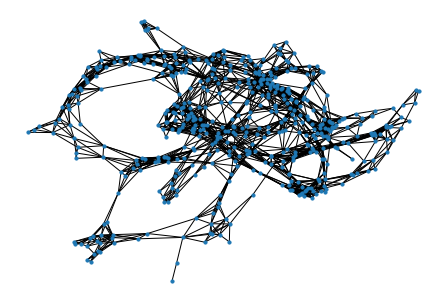

In [2]:
gen = get_graph_generator(500, 'geometric', radius=0.08)
graph = gen()
nx.draw(graph, node_size=10)

In [40]:
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

data = load_svmlight_file('./datasets/w8a')
# A_train = torch.DoubleTensor(StandardScaler().fit_transform(data[0].toarray())) \
#                 .to(DEVICE)
A_train = torch.DoubleTensor(data[0].toarray()).to(DEVICE)
c_train = torch.DoubleTensor(data[1]).to(DEVICE)
c_train[c_train == -1.] = 0.

n = 500
d = A_train.shape[1]
folder = StratifiedKFold(n_splits=n)
A_batches = []
c_batches = []

for train_ids, test_ids in folder.split(A_train.cpu(), c_train.cpu()):
    A_batches.append(A_train[test_ids])
    c_batches.append(c_train[test_ids])

c_train_processed = torch.cat(c_batches)

print(len(A_batches))
for b in A_batches[:10]:
    print(b.shape)

### Experiments

In [52]:
print('Smoothness estimate: {}'.format(((A_train**2).sum(dim=1).max() / 4.).item()))

Smoothness estimate: 28.5


In [55]:
%%time
X_starting = 5 * torch.ones((d, n), dtype=torch.float64).to(DEVICE).requires_grad_(True)
N_iter = 20000
regcoef = 1e-3

hist_gd_100 = projected_gradient(X_starting, A_batches, c_train_processed, regcoef, 
                                 gen_graph=get_graph_generator(n, 'geometric', radius=0.08), 
                                 N_inner=100, N_outer=N_iter//100)
hist_gd_25 = projected_gradient(X_starting, A_batches, c_train_processed, regcoef, 
                                gen_graph=get_graph_generator(n, 'geometric', radius=0.08), 
                                N_inner=25, N_outer=N_iter//25)
hist_gd_5 = projected_gradient(X_starting, A_batches, c_train_processed, regcoef, 
                               gen_graph=get_graph_generator(n, 'geometric', radius=0.08), 
                               N_inner=5, N_outer=N_iter//5)

# for (sync_steps, hist) in zip([100, 25, 5], [hist_gd_100, hist_gd_25, hist_gd_5]):
#     with open('./dumps/hist_gd_{}'.format(sync_steps), 'wb') as f:
#         pickle.dump(hist, f)

KeyboardInterrupt: 

In [53]:
# hist_acc_100 = acc_projected_gradient(X_starting, A_batches, c_train, 
#                                       N_inner=100, N_outer=N_iter//100)
# hist_acc_25 = acc_projected_gradient(X_starting, A_batches, c_train, 
#                                       N_inner=25, N_outer=N_iter//25)
# hist_acc_5 = acc_projected_gradient(X_starting, A_batches, c_train, 
#                                       N_inner=5, N_outer=N_iter//5)

# import pickle
# for (sync_steps, hist) in zip([100, 25, 5], [hist_acc_100, hist_acc_25, hist_acc_5]):
#     with open('./dumps/hist_acc_{}'.format(sync_steps), 'wb') as f:
#         pickle.dump(hist, f)

In [4]:
N_iter = 20000
hist_diging_01 = DIGing(X_starting, A_batches, c_train, N_iter=N_iter, alpha=0.1)
hist_diging_03 = DIGing(X_starting, A_batches, c_train, N_iter=N_iter, alpha=0.3)
hist_diging_05 = DIGing(X_starting, A_batches, c_train, N_iter=N_iter, alpha=0.5)
hist_diging_07 = DIGing(X_starting, A_batches, c_train, N_iter=N_iter, alpha=0.7)

import pickle
for (alpha, hist) in zip([1, 3, 5, 7], [hist_diging_01, hist_diging_03, 
                                       hist_diging_05, hist_diging_07]):
    with open('./dumps/hist_diging_0{}'.format(alpha), 'wb') as f:
        pickle.dump(hist, f)

### Plots

In [6]:
with open('./dumps/hist_acc_100', 'rb') as f:
    hist_acc_100 = pickle.load(f)
with open('./dumps/hist_acc_25', 'rb') as f:
    hist_acc_25 = pickle.load(f)
with open('./dumps/hist_acc_5', 'rb') as f:
    hist_acc_5 = pickle.load(f)

with open('./dumps/hist_gd_100', 'rb') as f:
    hist_gd_100 = pickle.load(f)
with open('./dumps/hist_gd_25', 'rb') as f:
    hist_gd_25 = pickle.load(f)
with open('./dumps/hist_gd_5', 'rb') as f:
    hist_gd_5 = pickle.load(f)

with open('./dumps/hist_diging_07', 'rb') as f:
    hist_diging_07 = pickle.load(f)
with open('./dumps/hist_diging_05', 'rb') as f:
    hist_diging_05 = pickle.load(f)
with open('./dumps/hist_diging_03', 'rb') as f:
    hist_diging_03 = pickle.load(f)
with open('./dumps/hist_diging_01', 'rb') as f:
    hist_diging_01 = pickle.load(f)

N_iter = 20000

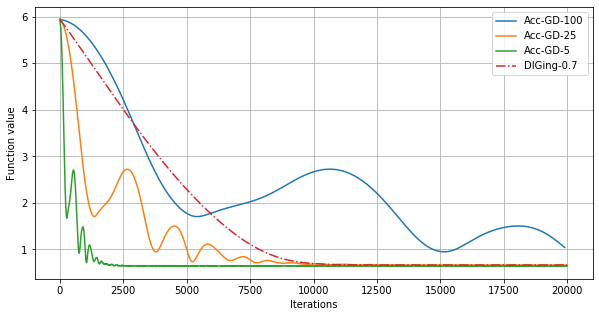

In [23]:
plt.figure(figsize=(10, 5))
fontsize = 10

for (sync_steps, hist) in zip([100, 25, 5], 
                              [hist_acc_100, hist_acc_25, hist_acc_5]):
    plt.plot(np.arange(0, N_iter, sync_steps), 
             hist['func'], '-', label='Acc-GD-{}'.format(sync_steps))

for (alpha, hist) in zip([7], [hist_diging_07]):
    plt.plot(hist['func'], '-.', label='DIGing-0.{}'.format(alpha))

ax = plt.gca()
# ax.set_yscale('log')
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel('Function value', fontsize=fontsize)
plt.legend(loc='upper right')
plt.grid()

# plt.savefig('./figures/acc_gd.png')

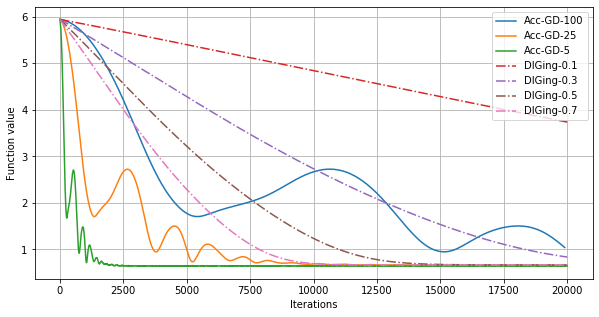

In [13]:
plt.figure(figsize=(10, 5))
fontsize = 10

# plt.subplot(121)
# for (sync_steps, hist) in zip([100, 25, 5], 
#                               [hist_gd_100, hist_gd_25, hist_gd_5]):
#     plt.plot(np.arange(0, N_iter, sync_steps), 
#              hist['func'], label='Proj-GD-{}'.format(sync_steps))

for (sync_steps, hist) in zip([100, 25, 5], 
                              [hist_acc_100, hist_acc_25, hist_acc_5]):
    plt.plot(np.arange(0, N_iter, sync_steps), 
             hist['func'], '-', label='Acc-GD-{}'.format(sync_steps))

for (alpha, hist) in zip([1, 3, 5, 7], [hist_diging_01, hist_diging_03, 
                                        hist_diging_05, hist_diging_07]):
    plt.plot(hist['func'], '-.', label='DIGing-0.{}'.format(alpha))

plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel('Function value', fontsize=fontsize)
plt.legend(loc='upper right')
plt.grid()

# plt.subplot(122)
# plt.plot((np.log(hist_diging['dist_from_k'])), label='DIGing')

# plt.plot(np.arange(0, N_iter, 100), 
#          np.log(hist_projected_100['dist_from_k']), 
#          label='Proj-GD-100')

# plt.plot(np.arange(0, N_iter, 25), 
#          np.log(hist_projected_25['dist_from_k']), 
#          label='Proj-GD-25')

# plt.plot(np.arange(0, N_iter, 5), 
#          np.log(hist_projected_5['dist_from_k']), 
#          label='Proj-GD-5')

# plt.xlabel('Iterations', fontsize=fontsize)
# plt.ylabel('log distance from K', fontsize=fontsize)
# plt.legend()
# plt.grid()